In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import utils
import numpy as np

import xwmt

from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt

import gsw
from cmip_basins.basins import generate_basin_codes

In [3]:
target = 'era5'
salinity = 'en4'
rootdir_en4 = '/scratch/gpfs/graemem/en4/'
rootdir_wmt = '/projects/SOCCOM/'
if target=='jra55':
    rootdir = '/projects/SOCCOM/'
    gridname = 'areacella_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-5-0_gr.nc'
    areaname = 'areacella'
    chunksize = 60
elif target=='era5':
    rootdir = '/'
    gridname = 'regular_grid.nc'
    areaname = 'rC'
    chunksize = 24
elif target=='merra2':
    rootdir = '/'
    gridname = 'regular_grid.nc'
    areaname = 'rC'
    chunksize = 60
elif target=='ecco':
    rootdir = '/projects/SOCCOM/'
    gridname = 'regular_grid.nc'
    areaname = 'rC'
    chunksize = 60
    
rootdir_ds=rootdir_wmt+'graemem/wmt/'+target+'/'
rootdir_grid = rootdir+'scratch/gpfs/graemem/'+target+'/'

In [4]:
ds = xr.open_zarr(rootdir_ds+target+'.'+salinity+'.ds.zarr')
grid = xr.open_dataset(rootdir_grid+gridname)
if target == 'era5':
    grid = grid.rename({'longitude':'lon','latitude':'lat'})

In [5]:
ds["areacello"] = grid[areaname].assign_coords({'lat':ds['lat'],'lon':ds['lon']})
ds["geolon"] = ds["lon"]*xr.ones_like(ds["lat"])
ds["geolon"] = ds["geolon"].transpose('lat','lon')
ds["geolat"] = ds["lat"]*xr.ones_like(ds["lon"])
ds["wet"] = np.isfinite(ds["sos"].isel(time=0)).drop('time')
if 'sfdsi' not in ds.data_vars:
    ds["sfdsi"] = xr.zeros_like(ds["hfds"])

In [6]:
basin = generate_basin_codes(ds, lon="lon", lat="lat", persian=True, style="cmip6")
ds["basin"] = basin.copy()
basin_dict = {'global':0,
              'southern':1,
               'atlantic':2,
               'pacific':3,
               'arctic':4,
               'indian':5,
               'mediterranean':6,
               'black':7,
               'hudson':8,
               'baltic':9,
               'red':10,
               'persian':11}
# Add additional basins to split up in different ways
basins=['atlantic','pacific']
for basin in basins:
    basin_dict[basin+'_tropc']=basin_dict[basin]
    basin_dict[basin+'_subtN']=basin_dict[basin]
    basin_dict[basin+'_subpN']=basin_dict[basin]
    basin_dict[basin+'_subtS']=basin_dict[basin]

In [7]:
ds = ds.rename({'lon': 'x', 'lat': 'y','geolat': 'lat', 'geolon': 'lon'})
# Chunk in time
ds = ds.chunk({'time':chunksize})

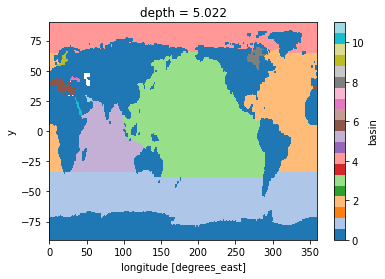

In [8]:
ds["basin"].plot(cmap="tab20")

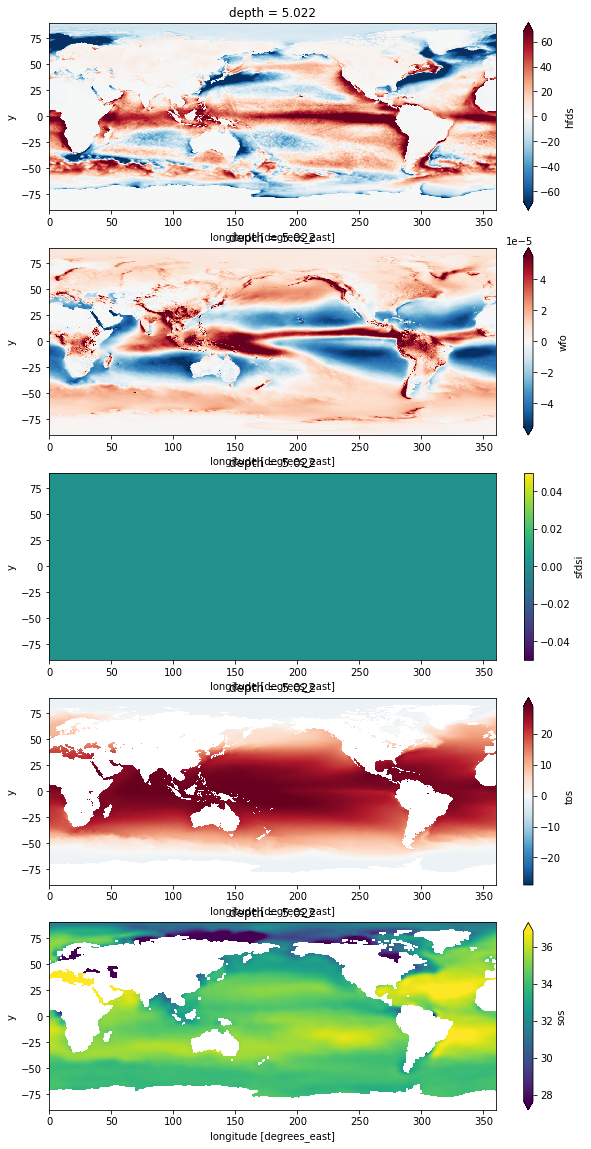

In [9]:
varnames = ['hfds','wfo','sfdsi','tos','sos']
nv = len(varnames)
fig,ax = plt.subplots(figsize=(10,4*nv),nrows=nv)
for i,varname in enumerate(varnames):
    da = ds[varname].isel(time=slice(0,120)).mean('time')
    da.plot(ax=ax[i],robust=True)

In [10]:
# Define bins
lstr = 'sigma0'
if lstr == 'sigma0':
    lmin = 10
    lmax = 30
    dl = 0.1
elif lstr == 'theta':
    lmin = -2
    lmax = 30
    dl = 0.5
elif lstr == 'salt':
    lmin = 20
    lmax = 40
    dl = 0.1
bins = np.arange(lmin,lmax,dl)

### Loop through basins

In [11]:
for basin_name in basin_dict.keys():
    print(basin_name)
    if basin_name=='global':
        dsnow = ds.copy()
    else:
        mask = ds["basin"]==basin_dict[basin_name]
        if basin_name[-6:]=='_tropc':
            mask = mask & (ds["lat"]<=20) & (ds["lat"]>=-20)
        if basin_name[-6:]=='_subtN':
            mask = mask & (ds["lat"]<=45) & (ds["lat"]>20)
        if basin_name[-6:]=='_subpN':
            mask = mask & (ds["lat"]>45)
        if basin_name[-6:]=='_subtS':
            mask = mask & (ds["lat"]>=-45) & (ds["lat"]<-20)
        
        dsnow = ds.where(mask,drop=True)

    G = xwmt.swmt(dsnow).G(lstr, bins=bins, group_tend=False)
    if lstr == 'sigma0':
        G['heat'] = G['heat'].assign_attrs({
            'long_name':'watermass transformation due to surface heat fluxes',
            'units':'m3s-1'})
        G['salt'] = G['salt'].assign_attrs({
            'long_name':'watermass transformation due to surface salt and freshwater fluxes',
            'units':'m3s-1'})
        
    with ProgressBar():
        G.to_netcdf(rootdir_ds+target+'.'+salinity+'.G-'+lstr+'-'+basin_name+'.nc',mode='w')

global
[########################################] | 100% Completed | 511.53 s
southern


/home/graemem/.conda/envs/core/lib/python3.10/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


[########################################] | 100% Completed | 183.86 s
atlantic


/home/graemem/.conda/envs/core/lib/python3.10/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


[########################################] | 100% Completed | 107.62 s
pacific


/home/graemem/.conda/envs/core/lib/python3.10/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


[########################################] | 100% Completed | 203.03 s
arctic


/home/graemem/.conda/envs/core/lib/python3.10/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


[########################################] | 100% Completed | 98.12 s
indian


/home/graemem/.conda/envs/core/lib/python3.10/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


[########################################] | 100% Completed | 62.95 s
mediterranean
[########################################] | 100% Completed | 21.04 s
black
[########################################] | 100% Completed | 16.39 s
hudson
[########################################] | 100% Completed | 19.26 s
baltic
[########################################] | 100% Completed | 17.21 s
red
[########################################] | 100% Completed | 16.87 s
persian
[########################################] | 100% Completed | 16.01 s
atlantic_tropc


/home/graemem/.conda/envs/core/lib/python3.10/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


[########################################] | 100% Completed | 47.92 s
atlantic_subtN


/home/graemem/.conda/envs/core/lib/python3.10/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


[########################################] | 100% Completed | 36.73 s
atlantic_subpN


/home/graemem/.conda/envs/core/lib/python3.10/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


[########################################] | 100% Completed | 31.99 s
atlantic_subtS
[########################################] | 100% Completed | 26.10 s
pacific_tropc


/home/graemem/.conda/envs/core/lib/python3.10/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


[########################################] | 100% Completed | 85.97 s
pacific_subtN


/home/graemem/.conda/envs/core/lib/python3.10/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


[########################################] | 100% Completed | 51.83 s
pacific_subpN


/home/graemem/.conda/envs/core/lib/python3.10/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


[########################################] | 100% Completed | 35.88 s
pacific_subtS


/home/graemem/.conda/envs/core/lib/python3.10/site-packages/xarray/core/indexing.py:1234: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


[########################################] | 100% Completed | 44.78 s


# SCRIBBLES

In [46]:
swmt(ds).G(lstr='sigma0',bins=bins,process=['hfds'])

TypeError: swmt.calc_G() got an unexpected keyword argument 'process'

In [ ]:
## MAIN
class swmt():
    masterdict = {
        "hfds":{'associated_scalar':'tos','flux_or_tendency':'flux','intensive_or_extensive':'extensive'},
        "sfdsi":{'associated_scalar':'sos','flux_or_tendency':'flux','intensive_or_extensive':'extensive'},
        "wfo":{'associated_scalar':'sos','flux_or_tendency':'flux','intensive_or_extensive':'extensive',
                'massflux':True,'scalar_in_massflux':0,'scalar_at_boundary':'sos'}
                 }
    
    def __init__(self,ds):
        data_vars = ds.data_vars
        # Check that all necessary attributes are there, or add them if not
        for data_var in data_vars:
            self[data_var]=ds[data_vars].copy()
            attrs = self[data_var].attrs
            
            if data_var in masterdict.keys:
                attrs_expected = masterdict[data_var]
                if attrs != attrs_expected:
                    # Return an error
                    # data_var has a CMOR convention name but the attributes don't match
            if 'associated_scalar' not in attrs:
                # Return an error
                
                # Or derive from cmor convention
              
    def G(lstr,bins,pstrs):
        if lstr=='sigma0' & lstr not in self.data_vars:
            l = calc_density(self.sa,self.theta)
        else:
            l = self[lstr]
        G = xr.Dataset()
        for pstr in pstrs:
            if lstr=='sigma0':
                process = calc_densityflux(self[pstr])
            elif self[pstr].attrs['associated_scalar']!=lstr:
                # Return an error, or simply zero?
                
            G[process]=_G_singleprocess(l,bins,process)

In [ ]:
## GRID


In [ ]:
## THERMODYNAMICS
def _calc_density(salinity,temperature,eos='teos10'):
    if eos=='teos10':
        return gsw.sigma0(salinity,temperature)
    
def _calc_alpha():
    
def _calc_beta():
    
def _calc_densityflux(process):
    attrs = process.attrs
    if attrs['associated_scalar']=='tos':
        coeff=self['alpha']*Cp
    elif attrs['associated_scalar']=='sos':
        coeff=self['beta']/self['rho0']
    return coeff*process

In [ ]:
## WMT
def _G_singleprocess(l,bins,process):
    hldot = calc_hldot(process)
    G = histogram(l,bins=bins,weights=hldot*area,dims=['x','y','z'])/np.diff(bins)

In [56]:
## PROCESS
def _calc_hldot(xgrid,process,intensive_or_extensive=None,flux_or_tendency=None):
    if (intensive_or_extensive=="intensive") & (flux_or_tendency=="flux"):
        hldot = hldot_from_Jl(xgrid,process)
    elif (intensive_or_extensive=="intensive") & (flux_or_tendency=="tendency"):
        hldot = hldot_from_ldot(xgrid,process)
    elif (intensive_or_extensive=="extensive") & (flux_or_tendency=="flux"):
        hldot = hldot_from_JL(xgrid,process)
    elif (intensive_or_extensive=="extensive") & (flux_or_tendency=="tendency"):
        hldot = hldot_from_Ldot(xgrid,process)
        
    return hldot

def _calc_hldot_massflux(xgrid,process,scalar_in_massflux,scalar_at_boundary):
    # Special case
    Jl = Jl_from_massflux(process,scalar_in_massflux,scalar_at_boundary)
    hldot = hldot_from_Jl(xgrid,Jl)
    
    return hldot
        
def calc_hldot(da,xgrid):
    
    ### Checking if it has necessary attributes ###
    attrs = da.attrs
    # Scrap attributes except those desired
    desired = ["flux_or_tendency","intensive_or_extensive","massflux","scalar_in_massflux","scalar_at_boundary"]
    attrs = dict_retain_keys(attrs,desired)
    if len(attrs)==0:
        print(processname+" has no WMT-relevant attributes so is not being considered")
        return
    
    ### Checking whether it is a 2D surface flux ###
    # If it is, place it on the very upper interface of the grid, and set zero elsewhere
    if "z_i" not in da.dims:
        ds[processname] = expand_surface_to_3D(ds[processname],ds["z_i"])
    
    # Special case that the process is associated with a boundary mass flux 
    # (commonly freshwater flux at the ocean surface)
    if "massflux" in attrs:
        # Requires that other attributes also be specified (could check for this higher up)
        if (attrs["scalar_in_massflux"] is None) or (attrs["scalar_at_boundary"] is None):
            print("To evaluate WMT due to boundary mass fluxes requires that the scalar"+
                  "concentration in the mass flux and the scalar concentration at the"+
                  "exposed boundary be specified")
        else:
            scalar_in_massflux = attrs["scalar_in_massflux"]
            if isinstance(attrs["scalar_at_boundary"],str):
                scalar_at_boundary = ds[attrs["scalar_at_boundary"]]
            else:
                scalar_at_boundary = attrs["scalar_at_boundary"]
            hldot = _calc_hldot_massflux(xgrid,ds[processname],scalar_in_massflux,scalar_at_boundary)
    else:
        hldot = _calc_hldot(xgrid,ds[processname],**attrs)
        
    return hldot

Data variables:
    hfds       (time, y, x) float32 dask.array<chunksize=(60, 320, 640), meta=np.ndarray>
    sos        (time, y, x) float32 dask.array<chunksize=(60, 320, 640), meta=np.ndarray>
    tos        (time, y, x) float32 dask.array<chunksize=(60, 320, 640), meta=np.ndarray>
    wfo        (time, y, x) float32 dask.array<chunksize=(60, 320, 640), meta=np.ndarray>
    wet        (time, y, x) bool dask.array<chunksize=(60, 320, 640), meta=np.ndarray>
    sfdsi      (time, y, x) float32 dask.array<chunksize=(60, 320, 640), meta=np.ndarray>
    areacello  (y, x) float32 dask.array<chunksize=(320, 640), meta=np.ndarray>
    lat        (y, x) float64 dask.array<chunksize=(320, 640), meta=np.ndarray>
    lon        (x, y) float64 dask.array<chunksize=(640, 320), meta=np.ndarray>